In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
init_printing()

In [2]:
p = symbols('p:3', real=True)
v = symbols('v:3', real=True)
f = symbols('f:3', real=True)
m = symbols('m', real=True)
t = symbols('t', real=True)
o = symbols('o:7', real=True)

In [3]:
a = [f_ / m for f_ in f]
model = Matrix([
    m,
    p[0] + v[0]*t + (a[0]*t**2)/2,
    p[1] + v[1]*t + (a[1]*t**2)/2,
    p[2] + v[2]*t + (a[2]*t**2)/2,
    v[0] + a[0]*t,
    v[1] + a[1]*t,
    v[2] + a[2]*t,
])
model

⎡        m        ⎤
⎢                 ⎥
⎢    2            ⎥
⎢f₀⋅t             ⎥
⎢───── + p₀ + t⋅v₀⎥
⎢ 2⋅m             ⎥
⎢                 ⎥
⎢    2            ⎥
⎢f₁⋅t             ⎥
⎢───── + p₁ + t⋅v₁⎥
⎢ 2⋅m             ⎥
⎢                 ⎥
⎢    2            ⎥
⎢f₂⋅t             ⎥
⎢───── + p₂ + t⋅v₂⎥
⎢ 2⋅m             ⎥
⎢                 ⎥
⎢    f₀⋅t         ⎥
⎢    ──── + v₀    ⎥
⎢     m           ⎥
⎢                 ⎥
⎢    f₁⋅t         ⎥
⎢    ──── + v₁    ⎥
⎢     m           ⎥
⎢                 ⎥
⎢    f₂⋅t         ⎥
⎢    ──── + v₂    ⎥
⎣     m           ⎦

In [4]:
J_model = model.jacobian((m,*p,*v))
J_model

⎡   1     0  0  0  0  0  0⎤
⎢                         ⎥
⎢     2                   ⎥
⎢-f₀⋅t                    ⎥
⎢───────  1  0  0  t  0  0⎥
⎢     2                   ⎥
⎢  2⋅m                    ⎥
⎢                         ⎥
⎢     2                   ⎥
⎢-f₁⋅t                    ⎥
⎢───────  0  1  0  0  t  0⎥
⎢     2                   ⎥
⎢  2⋅m                    ⎥
⎢                         ⎥
⎢     2                   ⎥
⎢-f₂⋅t                    ⎥
⎢───────  0  0  1  0  0  t⎥
⎢     2                   ⎥
⎢  2⋅m                    ⎥
⎢                         ⎥
⎢-f₀⋅t                    ⎥
⎢──────   0  0  0  1  0  0⎥
⎢   2                     ⎥
⎢  m                      ⎥
⎢                         ⎥
⎢-f₁⋅t                    ⎥
⎢──────   0  0  0  0  1  0⎥
⎢   2                     ⎥
⎢  m                      ⎥
⎢                         ⎥
⎢-f₂⋅t                    ⎥
⎢──────   0  0  0  0  0  1⎥
⎢   2                     ⎥
⎣  m                      ⎦

In [5]:
observe = randMatrix(3) @ Matrix(o[1:4])
observe

⎡48⋅o₁ + 37⋅o₂ + 60⋅o₃⎤
⎢                     ⎥
⎢14⋅o₁ + 82⋅o₂ + 41⋅o₃⎥
⎢                     ⎥
⎣99⋅o₁ + 33⋅o₂ + 77⋅o₃⎦

In [6]:
J_observe = observe.jacobian(o)
J_observe

⎡0  48  37  60  0  0  0⎤
⎢                      ⎥
⎢0  14  82  41  0  0  0⎥
⎢                      ⎥
⎣0  99  33  77  0  0  0⎦

In [7]:
lambda_model = lambdify((m,*p,*v,*f,t), model)
lambda_J_model = lambdify((m,*p,*v,*f,t), J_model)
lambda_observe = lambdify(o, observe)
lambda_J_observe = lambdify(o, J_observe)

In [8]:
def ekf(state, covar, control, measure, q=1e-3, r=1e-3):
    predict_state = lambda_model(*state[:,0], *control[:,0])
    F = lambda_J_model(*state[:,0], *control[:,0])
    Q = np.random.randn(*[F.shape[0]]*2) * q**0.5
    Q = Q @ Q.T
    predict_covar = F @ covar @ F.T + Q
    residual_state = measure - lambda_observe(*predict_state[:,0])
    H = lambda_J_observe(*predict_state[:,0])
    R = np.random.randn(*[H.shape[0]]*2) * r**0.5
    R = R @ R.T
    PHt = predict_covar @ H.T
    residual_covar = H @ PHt + R
    try:
        kalman_gain = PHt @ np.linalg.inv(residual_covar)
    except:
        return state, covar
    updated_state = predict_state + kalman_gain @ residual_state
    updated_covar = (np.identity(F.shape[0]) - (kalman_gain @ H)) @ predict_covar
    return updated_state, updated_covar

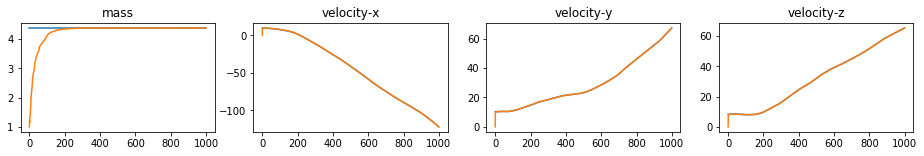

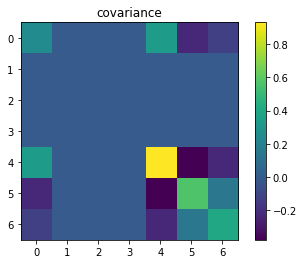

In [9]:
state_real = np.random.randn(7)[:,np.newaxis] * 10
state_real[0,0] = abs(state_real[0,0])
state_esti = np.array([1,0,0,0,0,0,0])[:,np.newaxis]
covar_esti = np.identity(state_esti.shape[0]) * 1e3
control = np.array([0,0,0,1e-2])[:,np.newaxis]
states = []
for i in range(1000):
    control[:3,0] += np.random.randn(3)
    state_real = lambda_model(*state_real[:,0], *control[:,0])
    measure = lambda_observe(*state_real[:,0])
    measure += np.random.randn(*measure.shape) * 1e-3
    state_esti, covar_esti = ekf(state_esti, covar_esti, control, measure)
    states.append(np.concatenate([state_real, state_esti], axis=-1))
states = np.array(states)
plt.figure(figsize=(16,2))
plt.subplot(141)
plt.title('mass')
plt.plot(states[:,0])
plt.subplot(142)
plt.title('velocity-x')
plt.plot(states[:,4])
plt.subplot(143)
plt.title('velocity-y')
plt.plot(states[:,5])
plt.subplot(144)
plt.title('velocity-z')
plt.plot(states[:,6])
plt.show()
plt.title('covariance')
plt.imshow(covar_esti)
plt.colorbar()
plt.show()